## 1. Data

In [848]:
# Import the libraries
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns

In [849]:
# Read the hero-network.csv data
heroNetwork = pd.read_csv(os.getcwd()+"/Data/hero-network.csv")

In [850]:
# lenght of the data
len(heroNetwork)

574467

As we can see, the lenght of the heroNetwork data is 574467. This data shows the edges between heroes that appear in the same comic. 

In [851]:
heroNetwork.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [853]:
# Read the edges.csv data
edges = pd.read_csv(os.getcwd()+"/Data/edges.csv")

### Data Preprocessing

#### 1. Some of the heroes' names in 'hero-network.csv' are not found in 'edges.csv'. This inconsistency will be solved in the bellow codes:

In [854]:
# Write a function to return the differences between two files
def compare(string1, string2):
    temp= []
    for i in string1:
        if i not in string2:
            temp.append(i)
    return temp

In [855]:
# Find the differnces between to files that have to modify
merge = heroNetwork.hero1.tolist() + heroNetwork.hero2.tolist()
unique = list(set(merge))
differ = compare(unique, list(edges.hero))
differ

['KILLER SHRIKE/SIMON ',
 'FIREFALL III/ARCHIE ',
 'JACK OF HEARTS/JACK ',
 'MAGNETO/MAGNUS/ERIC ',
 'WARRIOR WOMAN/JULIA ',
 'ROSS, GEN. THADDEUS ',
 'MANN, DR. J. VERNON ',
 'RINGER/ANTHONY TONY ',
 'BLACK FOX/ROBERT W. ',
 'APE MAN/GORDON MONK ',
 'WORTHINGTON, WARREN ',
 'CITYDWELLER/JERRY | ',
 'NORTHSTAR/JEAN-PAUL ',
 'SENSATIONAL HYDRA/A ',
 'JAMESON, COL. JOHN ',
 'CEREBRO MARK XIII | ',
 'ERISHKIGEL II/HOLLY ',
 'KLIGGER/SEN. EUGENE ',
 'GAMBIT/REMY LEBEAU ',
 'DIAMOND LIL/LILLIAN ',
 'BLACK AVENGER/JERRY ',
 'STUNT-MASTER/GEORGE ',
 'DARKOVER, PROFESSOR ',
 'GYRICH, HENRY PETER ',
 'MORBIUS/DR. MICHAEL ',
 'SPIDER-MAN/PETER PAR',
 'JUGGERNAUT | MUTANT ',
 'STARSHINE II/BRANDY ',
 'MORNING STAR/ZVEZDA ',
 'PURPLE MAN/ZEBEDIAH ',
 'JEFFRIES, MAGGIE ',
 'AGAMEMNON II/ANDREI ',
 'PINKERTON, PERCIVAL ',
 'MAN-SPIDER | MUTANT ',
 'AURORA/JEANNE-MARIE ',
 'TUMBLER/JOHN ROBERT ',
 'DR. STRANGE/STEPHEN ',
 'PROFESSOR X | EARTH ',
 'WATSON-PARKER, MARY ',
 'APOCALYPSE/EN SABAH ',
 'RAD

In [856]:
# Delete the words that don't have extra space from the differ list
differInEdge2 = ['BLADE' , 'SABRE' , 'SPIDER-MAN/PETER PAR']
for elem in differInEdge2:
    differ.remove(elem)
differ

['KILLER SHRIKE/SIMON ',
 'FIREFALL III/ARCHIE ',
 'JACK OF HEARTS/JACK ',
 'MAGNETO/MAGNUS/ERIC ',
 'WARRIOR WOMAN/JULIA ',
 'ROSS, GEN. THADDEUS ',
 'MANN, DR. J. VERNON ',
 'RINGER/ANTHONY TONY ',
 'BLACK FOX/ROBERT W. ',
 'APE MAN/GORDON MONK ',
 'WORTHINGTON, WARREN ',
 'CITYDWELLER/JERRY | ',
 'NORTHSTAR/JEAN-PAUL ',
 'SENSATIONAL HYDRA/A ',
 'JAMESON, COL. JOHN ',
 'CEREBRO MARK XIII | ',
 'ERISHKIGEL II/HOLLY ',
 'KLIGGER/SEN. EUGENE ',
 'GAMBIT/REMY LEBEAU ',
 'DIAMOND LIL/LILLIAN ',
 'BLACK AVENGER/JERRY ',
 'STUNT-MASTER/GEORGE ',
 'DARKOVER, PROFESSOR ',
 'GYRICH, HENRY PETER ',
 'MORBIUS/DR. MICHAEL ',
 'JUGGERNAUT | MUTANT ',
 'STARSHINE II/BRANDY ',
 'MORNING STAR/ZVEZDA ',
 'PURPLE MAN/ZEBEDIAH ',
 'JEFFRIES, MAGGIE ',
 'AGAMEMNON II/ANDREI ',
 'PINKERTON, PERCIVAL ',
 'MAN-SPIDER | MUTANT ',
 'AURORA/JEANNE-MARIE ',
 'TUMBLER/JOHN ROBERT ',
 'DR. STRANGE/STEPHEN ',
 'PROFESSOR X | EARTH ',
 'WATSON-PARKER, MARY ',
 'APOCALYPSE/EN SABAH ',
 'RADIOACTIVE MAN/DR. ',
 'MR.

In [857]:
# Deleting the extra space from the end of the some words in heroNetwork
for col in heroNetwork.columns:
    heroNetwork[col] = heroNetworkDf[col].apply(lambda x: x[0:-1] if x in differ else x)

In [858]:
# Cleaning edges from the extra '/'
edges.hero = edges.hero.apply(lambda x: x[0:-1] if x in ["BLADE/", "SABRE/"] else x)

In [859]:
# Fix the name 'SPIDER-MAN/PETER PAR' in 'hero-network.csv'
for col in heroNetwork.columns:
        heroNetwork[col] = heroNetwork[col].apply(lambda x: 'SPIDER-MAN/PETER PARKER' if x=='SPIDER-MAN/PETER PAR' else x)

In [860]:
# Check if there is any differences between the hero's names in 2 files
merge = heroNetwork.hero1.tolist() + heroNetwork.hero2.tolist()
unique2 = list(set(merge))
differ2 = compare(unique2, list(edges.hero))
differ2

[]

As we can see, we got the blank list from the compare function. It means all tree reasons that caused inconsistency were fixed.

In [861]:
# Save the modified version of edges file as csv
edges.to_csv(os.getcwd()+"/Data/edgesModified.csv", index=False , header = True)

#### 2. Some entries in the 'hero-network.csv' have the same hero in both columns. We will handle it in the following codes:

In [862]:
# Delete the rows that have the same hero in both columns
heroNetwork = heroNetwork[heroNetwork.hero1!=heroNetwork.hero2] 

In [863]:
# Save the modified heroNetwork as csv files
heroNetwork.to_csv(os.getcwd()+"/Data/heroNetworkModified.csv", index=False , header = True)

In [864]:
# Read the modified file
heroNetworkModified = pd.read_csv(os.getcwd()+"/Data/heroNetworkModified.csv")

### Making Graphs

#### 1.First Graph

For each pair of nodes (ie for each edge), we have two attributes :
1. capicity : number of links between the two nodes (necessary for functionality 4)
2. weight : 1/capicity 

In [865]:
full_df_size = heroNetworkModified.groupby(['hero1', 'hero2'], as_index=False).size()

full_df_size = full_df_size.rename(columns={'size':'capacity'})

full_df_size['weight'] = 1/full_df_size['capacity']

full_df_size

,hero1,hero2,capacity,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1,1.0
1,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1,1.0
2,24-HOUR MAN/EMMANUEL,M'SHULLA,1,1.0
3,3-D MAN/CHARLES CHAN,ANGEL/WARREN KENNETH,1,1.0
4,3-D MAN/CHARLES CHAN,ANT-MAN II/SCOTT HAR,1,1.0
...,...,...,...,...
224094,ZZZAX,"RODRIGUEZ, DEBRA",1,1.0
224095,ZZZAX,"ROSS, GEN. THADDEUS",2,0.5
224096,ZZZAX,"SUMMERS, NATHAN CHRI",1,1.0
224097,ZZZAX,TIGRA/GREER NELSON,1,1.0


In [866]:
# Making the first weighted and undirected graph from the heroNetworkModified data
GHeroNet = nx.from_pandas_edgelist(full_df_size, source='hero1', target='hero2', edge_attr=['weight', 'capacity'], 
                                   create_using=nx.MultiGraph(), edge_key=None)
                                

We can notice that for each pair of nodes, we can have two different lists of attributes on some edges :

In [867]:
GHeroNet.get_edge_data('ABRAXAS','FROST, CARMILLA')

{0: {'weight': 1.0, 'capacity': 1}, 1: {'weight': 0.5, 'capacity': 2}}

In [868]:
GHeroNet.get_edge_data('FROST, CARMILLA','ABRAXAS')

{0: {'weight': 1.0, 'capacity': 1}, 1: {'weight': 0.5, 'capacity': 2}}

This is because each pair of nodes was not necessarily added in the dataset each time in the same order.
For example, if in a comic A, we have SpiderMan and CaptainAmerica and this pair is added with SpiderMan as hero1 and CaptainAmerica as hero2. Then, we can have a comic B where they reappear together and this time the pair will be added with CaptainAmerica in hero1 and SpiderMan in hero2.

Let's recreate this undirected graph in order to have only one edge between each pair of nodes. Also, we want to recalculate capacities and weights for each edge to have only one correct value.

In [869]:
G_heroes = nx.Graph()

for edge in tqdm(GHeroNet.edges) :
    if edge[2] == 0 :
        links_dico_values = GHeroNet.get_edge_data(edge[0], edge[1]).values()
        total_capacity = 0
        for values in links_dico_values :
            total_capacity += values['capacity']
        total_weight = 1/total_capacity
        G_heroes.add_edge(edge[0], edge[1], weight=total_weight, capacity=total_capacity)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224099/224099 [00:00<00:00, 417800.02it/s]


We can see that now we have attributes only one time for each edge. So, the weights are corrects now.

In [870]:
G_heroes.name = 'Heroes'

In [871]:
G_heroes.get_edge_data('ABRAXAS','FROST, CARMILLA')

{'weight': 0.3333333333333333, 'capacity': 3}

#### 2.Second Graph

In [872]:
# Making the second unweighted and undirected graph with 'nodes.csv' and 'edgesModified.csv' data
# First we have to prepare and read the needed data
# Read the edgesModified data and convert it to a dataframe
edgesModified = pd.read_csv(os.getcwd()+"/Data/edgesModified.csv")

In [873]:
edgesDfModified = pd.DataFrame(edgesModified)

In [874]:
# Read the nodes.csv file
nodes = pd.read_csv('./Data/nodes.csv')

In [875]:
# Convert the nodes.csv data to a dataframe
nodesDf = pd.DataFrame(nodes)

In [876]:
# By examining the nodesDf dataset, we understood that in this dataset there are some heros'name that are differenet from their 
# name in the edges dataset. So we are going to handle it.
nodesDf.node = nodesDf.node.apply(lambda x: x[0:-1] if x in ["BLADE/", "SABRE/"] else x)

In [877]:
# Check
nodesDf[nodesDf.node=="SABRE/"]

,node,type


In [878]:
# Save the modified version of the nodes data
nodesDf.to_csv(r'./Data/nodesModified.csv', index=False , header = True)

In [879]:
# Read the nodesModified.csv
nodesModified = pd.read_csv('./Data/nodesModified.csv')

In [880]:
# Convert the nodesModified.csv to a Dataframe
nodesDfModified = pd.DataFrame(nodesModified)

In [881]:
nodesModified

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


Now, we can start to make a graph. The type of node (hero/comic) can be found in 'nodesDfModified', and an edge between a hero node and a comic node can be found in 'edgesDfModified' when the hero has appeared in that specific comic.

In [882]:
# Make a graph from edges dataframe
GHerosComics = nx.from_pandas_edgelist(edgesModified, source='hero', target = 'comic')

In [883]:
# For merging two dictionaries
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [884]:
typesHero = {i:{"label":"hero"} for i in edgesDfModified.hero}
typesComics = {i:{"label":"comic"} for i in edgesDfModified.comic}
nodeTypes = Merge(typesHero, typesComics)

In [885]:
nx.set_node_attributes(GHerosComics, nodeTypes)

In [886]:
# Add nodes from nodes dataframe with their types that show us if they are hero or comic
GHerosComics.add_nodes_from(nodesDfModified[nodesDfModified['type']== 'hero']['node'], label = 'hero')
GHerosComics.add_nodes_from(nodesDfModified[nodesDfModified['type']== 'comic']['node'], label = 'comic')
GHerosComics.name = 'Heroes and comics'

In [887]:
# Checking if still there exist nodes without type (label)
for node in GHerosComics.nodes:
    try:
        secondGraph.nodes[node]['label']
    except:
        print(node)

In [888]:
# Number of nodes
len(list(GHerosComics.nodes))

19089

In [889]:
# Number of edges
len(list(GHerosComics.edges))

96104

## 2. Backend Implementation

We first define the Controller System and the function to get the top N heroes (based on the number of comics in which they appear).

In [890]:
import warnings

In [894]:
# Having a log function to hanlde errors, messages, and warnings
def logFunction(message, severity=0):
    if severity==0:
        print(message)
    elif severity==1:
        warnings.warn(message)
    else:
        raise ValueError(message)

In [896]:
# Function that finds top N heroes. It first sorts them in ascending order and then return the first N items.
def getTopNHeroes(N):
    topNHeroes = edgesDfModified.groupby('hero').size().sort_values(ascending=False)
    return list(topNHeroes.head(N).index)

#### Example of top 10 heroes :

In [897]:
# The top 10 heroes who have appeared in the most number of comics
n = 10
print(f"Top {n} heros are:\n", *getTopNHeroes(n), sep='\n')

Top 10 heros are:

SPIDER-MAN/PETER PARKER
CAPTAIN AMERICA
IRON MAN/TONY STARK
THING/BENJAMIN J. GR
THOR/DR. DONALD BLAK
HUMAN TORCH/JOHNNY S
MR. FANTASTIC/REED R
HULK/DR. ROBERT BRUC
WOLVERINE/LOGAN
INVISIBLE WOMAN/SUE


In [899]:
# The controller system takes in input some variable arguments because the functionalities don't have the same arguments.
# It gets the N top heroes and compute the subgraph related to those heroes.
# Then, it calls the desired functionnality.
def ControllerSystem(G: nx.Graph, i, N=0, **kwargs):
    
    # Input control mechanisms    
    if not (N>=0):
        logFunction("Number of heros must be equal or greater than zero. Zero returns the resutls for the entire graph.", 2)
    
    # Controlling the inputs for a given functionality
    
    # For Functionality 1
    if i==1:
        if 'graphType' not in kwargs:
            logFunction("The 'graphType' argument is not defined.", 2)
            
        if kwargs['graphType']==1 and G.name != 'Heroes':
            logFunction("The given graph type parameter does not match the given graph.", 2)
        elif kwargs['graphType']==2 and G.name != 'Heroes and comics':
            logFunction("The given graph type parameter does not match the given graph.", 2)
        elif kwargs['graphType'] not in range(1,3):
            logFunction("The type of the graph can be either 1 or 2.", 2)
            
    # For Functionality 2
    elif i==2: 
        if 'metrics' not in kwargs:
            logFunction("The 'metrics' argument is not defined.", 2)
            
        metrices = ['Betweeness', 'PageRank', 'ClosenessCentrality', 'DegreeCentrality']
        if kwargs['metrics'] not in metrices:
            logFunction("The given metrics value is wrong.", 2)
    
    # For Functionality 3
    elif i==3:
        
        if G.name != 'Heroes and comics':
            logFunction("This functionality can only be caried out over the second graph.", 2)

        if 'init_node' not in kwargs:
            logFunction("'init_node' argument is not defined.", 2)
        elif 'end_node' not in kwargs:
            logFunction("'end_node' argument is not defined.", 2)   
        elif 'h' not in kwargs:  
            logFunction("'h' (hero lsit) argument is not defined.", 2)
    
    # For Functionality 4
    elif i==4:
        
        if 'heroA' not in kwargs:
            logFunction("'heroA' argument is not defined.", 2)
        elif 'heroB' not in kwargs:
            logFunction("'heroB' argument is not defined.", 2)
    
    # For Functionality 5
    elif i==5:
        if 'Hero_1' not in kwargs:
            logFunction("'Hero_1' argument is not defined.", 2)
        elif 'Hero_2' not in kwargs:
            logFunction("'Hero_2' argument is not defined.", 2)
    
    elif i not in range(1,6):
        logFunction("The requested functionality does not exists. i must be between 1 and 5.", 2)
    
    
    # Now if all inputs meet their respected criteria, we build the graph
    # in case a limited number of top heroes is requesdted
    if N != 0:        
        topHeroes = getTopNHeroes(N)
        
        if G.name == 'Heroes':
                G = G_heroes.subgraph(topHeroes)

        elif G.name == 'Heroes and comics':
            topComics = []
            for topHero in topHeroes:
                topComics = [*topComics,*list(nx.neighbors(G, topHero))]
            topHeroes = [*topHeroes, *topComics] 
            G = G.subgraph(topHeroes)

        else:
            logFunction("The given graph is neither of heroes or heroes&comics graphs.", 2)

        # Check and see if the given set of heros are presented in the requested top N subgraph
        if i==3:
            for hero in kwargs['h']:
                if hero not in G.nodes:
                    logFunction(f"From the given sequence of heroes, {hero} is not present on the top {N} heros list.", 2)
    
    # This will be used in visualization part.
    if 'verbose' in kwargs:
        if kwargs['verbose'] == True:
            print(f"Visualization of Functionality {i} for graph '{G.name}'")
    
    #If N=0, we just pass the whole graph
    return globals()['function_'+str(i)](G, N, **kwargs)

### Functionality 1 - extract the graph's features

In [900]:
from collections import Counter
def function_1(G, N, **kwargs):
    
    # A return dictionary that collects the results of the functionality
    res = {}
    
    # 1)The number of nodes in the network (if type 2, report for both node types)
    if kwargs['graphType']==1:
        res['heroes'] = list(G.nodes)
        res['Number of Nodes'] = len(G.nodes)
    else:
        # Number of each nodes' types in the network
        tmp = [node for node in G.nodes if G.nodes[node]['label'] == 'hero']
        numberOfComics= len([node for node in G.nodes if G.nodes[node]['label'] == 'comic'])
        numberOfHeroes= len(tmp)
        res['Number of Nodes'] = [numberOfComics, numberOfHeroes]
        res['heroes'] = tmp
    
    # 2)The number of collaborations of each superhero with the others (only if type 1)  
    if kwargs['graphType']==1: 
        res['Collaborations'] = [G.degree(i) for i in G.nodes] 
    
    # 3)The number of heroes that have appeared in each comic (only if type 2)
    if kwargs['graphType']==2:
        res['Number of Heroes'] = [[],[]]
        numOfHeroInComic = []
        comicNodes = [node for node in G.nodes if G.nodes[node]['label'] == 'comic']
        for i in comicNodes:
            res['Number of Heroes'][0].append(i)
            res['Number of Heroes'][1].append(G.degree(i))
    
    # 4)The network's density. The networkx code: nx.density(G)
    n = G.number_of_nodes()
    e = G.number_of_edges()
    if n <= 1 or e ==0:
        density = 0
    density = e / (n * (n - 1))
    if not G.is_directed():
            density *= 2
    res['Density'] = density
    
    # 5)The network's degree distribution list of the frequency of each degree value.
    #   The code with nx: nx.degree_histogram(secondGraph)
    counts = Counter(d for n, d in G.degree())
    frequencyOfDegree = [counts.get(i, 0) for i in range(max(counts) + 1)]
    res['DegreeDist'] = frequencyOfDegree

    # 6)The average degree of the network
    avgDegree = np.mean(list(dict(G.degree()).values()))
    res['Average Degree'] = avgDegree

    # 7)The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
    percentile95 = np.quantile(list(dict(G.degree()).values()), 0.95)
    hub = [node for node, degree in G.degree() if degree >= percentile95]
    res['hub'] = hub

    # 8)Whether the Network is sparse or dense
    if nx.density(G) < 0.1:
        sparsity = "sparse"
    else:
        sparsity = "dense"
    res['Sparsity'] = sparsity
        
    return res

### Functionality 2 - Find top superheroes!

In [909]:
def function_2(G, N, **kwargs):
    
    # Initializing needed paratmetrs
    metrics = kwargs['metrics']
    res = {}
    res['metrics'] = metrics
    
    # Error check
    if kwargs['node'] not in G.nodes:
        logFunction("The given node does not exists in the requested graph.", 2)
    
    # Betweeness metrics
    if metrics == 'Betweeness':
        res['subGraph'] = nx.betweenness_centrality(G, normalized=True, weight='weight') # for subgraph
        res['node'] = [kwargs['node'], res['subGraph'][kwargs['node']]]                  # for node
    # PageRank metrics
    elif metrics == 'PageRank':
        res['subGraph'] = nx.pagerank(G, weight='weight')                                # for subgraph
        res['node'] = [kwargs['node'], res['subGraph'][kwargs['node']]]                  # for node
    # ClosenessCentrality metrics
    elif metrics == 'ClosenessCentrality':
        res['node'] = [kwargs['node'], nx.closeness_centrality(G, u=kwargs['node'])]     
    # DegreeCentrality metrics
    else:
        res['subGraph'] = nx.degree_centrality(G)                                        # for subgraph
        res['node'] = [kwargs['node'], res['subGraph'][kwargs['node']]]                  # for node
    
    return res

In [910]:
resultF2 = ControllerSystem(G_heroes, 2, N=10, node='CAPTAIN AMERICA', metrics='Betweeness')
resultF2

{'metrics': 'Betweeness',
 'subGraph': {'SPIDER-MAN/PETER PARKER': 0.0,
  'IRON MAN/TONY STARK': 0.0,
  'CAPTAIN AMERICA': 0.19444444444444442,
  'HUMAN TORCH/JOHNNY S': 0.08333333333333333,
  'WOLVERINE/LOGAN': 0.0,
  'INVISIBLE WOMAN/SUE': 0.0,
  'THING/BENJAMIN J. GR': 0.08333333333333333,
  'MR. FANTASTIC/REED R': 0.0,
  'THOR/DR. DONALD BLAK': 0.0,
  'HULK/DR. ROBERT BRUC': 0.0},
 'node': ['CAPTAIN AMERICA', 0.19444444444444442]}

### Functionality 3 - Shortest ordered Route

In [911]:
def function_3(G, N, **kwargs):
    
    # The sequence of heroes given as input
    heroSequence = [kwargs['init_node'], *kwargs['h'], kwargs['end_node']]
    
    # Building the subgraph in case of N not being zero
    if N!= 0:
        topHeroes = getTopNHeroes(N)
        topComics = []
        for node in G.nodes:
            if G.nodes[node]['label']=='comic' and len(set(G.neighbors(node)).intersection(topHeroes)):
                topComics.append(node)
        G = GHerosComics.subgraph([*topHeroes, *topComics])
    
    # Initializing needed parameters
    res = {}
    shortestPath = []
    
    # Iterating between each two consecutive nodes and finding the shortest path between them
    for i in range(len(heroSequence)-1):
        try:
            shortestPath.append(nx.shortest_path(G, source=heroSequence[i], target=heroSequence[i+1]))
        except:
            print("There is no such path.")
    
    # Returning resutls
    res['shortestPath'] = shortestPath
    res['graph'] = G
    return res

In [912]:
tmpVal = getTopNHeroes(100)
ControllerSystem(GHerosComics, 3, N=100, init_node=tmpVal[0], end_node=tmpVal[-1], h=tmpVal[1:-1])['shortestPath']

[['SPIDER-MAN/PETER PARKER', 'A 11', 'CAPTAIN AMERICA'],
 ['CAPTAIN AMERICA', "A '00", 'IRON MAN/TONY STARK'],
 ['IRON MAN/TONY STARK', 'A 1', 'THING/BENJAMIN J. GR'],
 ['THING/BENJAMIN J. GR', 'A 1', 'THOR/DR. DONALD BLAK'],
 ['THOR/DR. DONALD BLAK', 'A 1', 'HUMAN TORCH/JOHNNY S'],
 ['HUMAN TORCH/JOHNNY S', 'A 1', 'MR. FANTASTIC/REED R'],
 ['MR. FANTASTIC/REED R', 'A 1', 'HULK/DR. ROBERT BRUC'],
 ['HULK/DR. ROBERT BRUC', 'A3 10', 'WOLVERINE/LOGAN'],
 ['WOLVERINE/LOGAN', 'A3 10', 'INVISIBLE WOMAN/SUE'],
 ['INVISIBLE WOMAN/SUE', 'A 1', 'SCARLET WITCH/WANDA'],
 ['SCARLET WITCH/WANDA', 'A 10', 'BEAST/HENRY &HANK& P'],
 ['BEAST/HENRY &HANK& P', 'A 157', 'DR. STRANGE/STEPHEN'],
 ['DR. STRANGE/STEPHEN', 'A 168', 'WATSON-PARKER, MARY'],
 ['WATSON-PARKER, MARY', 'ASM2 1', 'DAREDEVIL/MATT MURDO'],
 ['DAREDEVIL/MATT MURDO', 'A 111', 'HAWK'],
 ['HAWK', 'A 10', 'VISION'],
 ['VISION', 'A 110', 'CYCLOPS/SCOTT SUMMER'],
 ['CYCLOPS/SCOTT SUMMER', 'A 3', 'WASP/JANET VAN DYNE'],
 ['WASP/JANET VAN DYNE',

### Functionality 4 - Disconneted Graphs

In [786]:
def function_4(G, N=0, **kwargs):
    
    min_n_links, (subsetA, subsetB) = nx.minimum_cut(G, kwargs['heroA'], kwargs['heroB'], capacity='capacity')

    return min_n_links, G.subgraph(list(subsetA)), G.subgraph(list(subsetB)), G

In [787]:
min_n_links, subsetA, subsetB, G = ControllerSystem(G_heroes, 4, 20, heroA='IRON MAN/TONY STARK', heroB='SPIDER-MAN/PETER PARKER')
min_n_links

2051

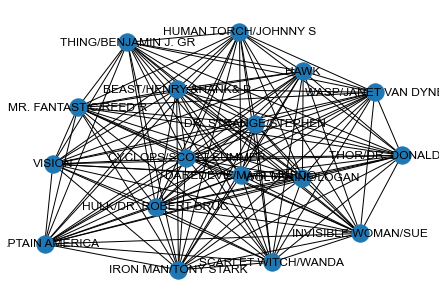

In [778]:
plt.clf()
nx.draw(subsetA, with_labels=True)
plt.show()

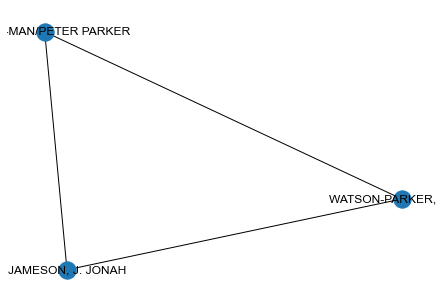

In [780]:
plt.clf()
nx.draw(subsetB, with_labels=True)
plt.show()

### Functionality 5 - Extracting Communities

In [913]:
# remove the node with highest EBC score from the graph
def removeEdge(graph):
	# We use capacity attribute of edges here as weight because we want heroes that are mostly together in comics to be in the same community
	G_dict = nx.edge_betweenness_centrality(graph, weight='capacity')

	edge = sorted(G_dict.items(), key=lambda item: item[1], reverse = True)[0][0]
	graph.remove_edge(edge[0], edge[1])

	return graph

# we remove nodes with highest EBC score until we have only one connected component
def girvanNewman(graph):
	nConnectedComponents = nx.number_connected_components(graph)
	min_edges = 0

	while(nConnectedComponents == 1):
		graph = removeEdge(graph.copy())
		nConnectedComponents = nx.number_connected_components(graph)
		min_edges += 1

	return graph, min_edges

# function_5 takes in input some variable arguments in kwargs that must contain Hero_1 and Hero2 values
def function_5(G, N=0, **kwargs) :

	# we use divise method with Girvan Newman algorithm to extract communities from the graph
	G, min_edges = girvanNewman(G)

	# we extract the communities of the new graph
	communities = []
	connectedComponents = nx.connected_components(G)
	for community in connectedComponents :
		communities.append(community)

	# we check if hero1 and hero2 are in a same community
	same_community = False
	for community in communities :
		if kwargs['Hero_1'] in community and kwargs['Hero_2'] in community :
			same_community = True

	return min_edges, communities, same_community, G


In [914]:
min_edges, communities, same_community, G = ControllerSystem(G_heroes, 5, 50, Hero_1='CAPTAIN AMERICA', Hero_2='IRON MAN/TONY STARK')

In [915]:
same_community

True

In [916]:
min_edges

327

In [917]:
len(communities)

2

In [918]:
communities

[{'ANGEL/WARREN KENNETH',
  'ANT-MAN/DR. HENRY J.',
  'BEAST/HENRY &HANK& P',
  "BLACK PANTHER/T'CHAL",
  'BLACK WIDOW/NATASHA',
  'CANNONBALL II/SAM GU',
  'CAPTAIN AMERICA',
  'CAPTAIN BRITAIN/BRIA',
  'COLOSSUS II/PETER RA',
  'CYCLOPS/SCOTT SUMMER',
  'DAREDEVIL/MATT MURDO',
  'DR. DOOM/VICTOR VON',
  'DR. STRANGE/STEPHEN',
  'FURY, COL. NICHOLAS',
  'HAWK',
  'HERCULES [GREEK GOD]',
  'HULK/DR. ROBERT BRUC',
  'HUMAN TORCH/JOHNNY S',
  'ICEMAN/ROBERT BOBBY',
  'INVISIBLE WOMAN/SUE',
  'IRON MAN/TONY STARK',
  'JAMESON, J. JONAH',
  'JARVIS, EDWIN',
  'JONES, RICHARD MILHO',
  'MARVEL GIRL/JEAN GRE',
  'MR. FANTASTIC/REED R',
  'NELSON, FRANKLIN FOG',
  'NIGHTCRAWLER/KURT WA',
  'ODIN [ASGARDIAN]',
  'PARKER, MAY',
  'PROFESSOR X/CHARLES',
  'QUICKSILVER/PIETRO M',
  'RICHARDS, FRANKLIN B',
  'ROBERTSON, JOE',
  'ROGUE /',
  'SCARLET WITCH/WANDA',
  'SHADOWCAT/KATHERINE',
  'SHE-HULK/JENNIFER WA',
  'SILVER SURFER/NORRIN',
  'SPIDER-MAN/PETER PARKER',
  'STORM/ORORO MUNROE S',
  'S

## 3. Frontend Implementation

### Visualization 1 - Visualize some features of the network

In [437]:
# Configuring plotting and printing 
sns.set_style('darkgrid')
# Printing splitter for better visibility
def splitter(n):
    tmp = ""
    for i in range(n):
        tmp += "="
    print(tmp)

In [922]:
def visualizaion_1(res, limit=50):
    
    heroes = res['heroes']
    
    # pringting general informations
    print("\nGeneral Information:")
    splitter(50)
    info_list = ['Number of Nodes', 'Density', 'Average Degree', 'Sparsity']
    format_row = "{:>30}" * 2
    if type(res[info_list[0]])=='list':
        print(format_row.format('Number of Nodes', f"Heroes:{res[info_list[0]][1]}, Comics:{res[info_list[0]][0]}"))
        for i in info_list[1:]:
            print(format_row.format(i, res[i]))
    else:
        for i in info_list:
            print(format_row.format(i, res[i]))
    splitter(50)
    
    # Network hubs
    print("\nNetowks Hubs:")
    splitter(50)
    for i in range(len(res['hub'])//5+1):
        print ("".join(f"'{res['hub'][i*5:(i+1)*5]}'") + "\n")
    splitter(50)
    
    # Plotting different criteri based on the passed graph
    if 'Collaborations' in res.keys():
        # Sorting based on colaborations (descending order)
        sorted_colabs, sorted_hero= list(zip(*sorted(zip(res['Collaborations'], heroes), reverse=True)))
        # Plotting
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.plot(range(len(sorted_colabs)), sorted_colabs)
        ax.set_xticks(range(len(sorted_colabs)), sorted_hero, rotation='vertical')
        ax.set_title(f'Number of collaborations for the top {len(sorted_colabs)} heroes.')
        ax.set_xlabel('Heroes')
        ax.set_ylabel('Number of Collabrations')
    
    if 'Number of Heroes' in res.keys():
        # Sorting based on number of heroes (descending order)
        sorted_heroes_number, sorted_comics= list(zip(*sorted(zip(res['Number of Heroes'][1], res['Number of Heroes'][0]),
                                                             reverse=True)))
        sorted_heroes_number = sorted_heroes_number[:limit]
        sorted_comics = sorted_comics[:limit]
        x = range(len(sorted_heroes_number))
        
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.plot(x, sorted_heroes_number)
        ax.set_xticks(x, sorted_comics, rotation='vertical')
        ax.set_title(f'Number of heroes in each comic.')
        ax.set_xlabel('Comic')
        ax.set_ylabel('Number of Heroes')
    
    # Plotting different criteri based on the passed graph
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.hist(res['DegreeDist'], bins=15)
    ax.set_title(f"Distribution of nodes' degree (To see which degree is more frequent).")
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')

Visualization of Functionality 1 for graph 'Heroes'

General Information:
               Number of Nodes                            50
                       Density            0.9746938775510204
                Average Degree                         47.76
                      Sparsity                         dense

Netowks Hubs:
'['SPIDER-MAN/PETER PARKER', 'WOLVERINE/LOGAN', 'STORM/ORORO MUNROE S', 'ICEMAN/ROBERT BOBBY', 'SILVER SURFER/NORRIN']'

'['CAPTAIN AMERICA', 'HUMAN TORCH/JOHNNY S', 'SCARLET WITCH/WANDA', 'MARVEL GIRL/JEAN GRE', 'WONDER MAN/SIMON WIL']'

'['THING/BENJAMIN J. GR', 'BEAST/HENRY &HANK& P', 'CYCLOPS/SCOTT SUMMER', 'IRON MAN/TONY STARK', 'INVISIBLE WOMAN/SUE']'

'['ANGEL/WARREN KENNETH', 'DR. STRANGE/STEPHEN', 'ANT-MAN/DR. HENRY J.', 'SHE-HULK/JENNIFER WA', 'SUB-MARINER/NAMOR MA']'

'['THOR/DR. DONALD BLAK', 'BLACK WIDOW/NATASHA', 'WASP/JANET VAN DYNE', 'HULK/DR. ROBERT BRUC', 'MR. FANTASTIC/REED R']'

'['COLOSSUS II/PETER RA', 'VISION']'



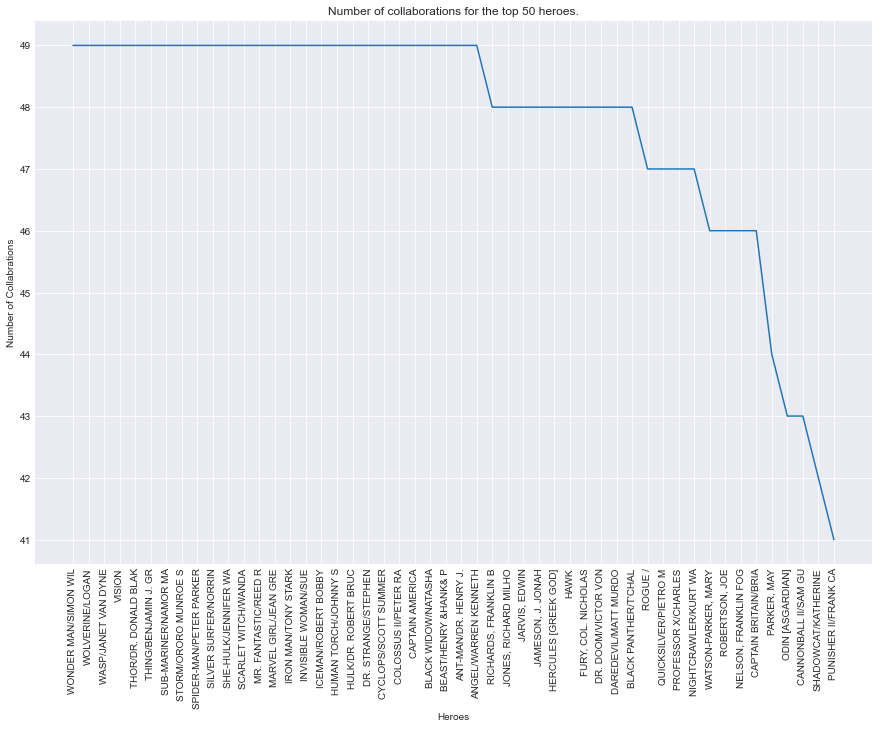

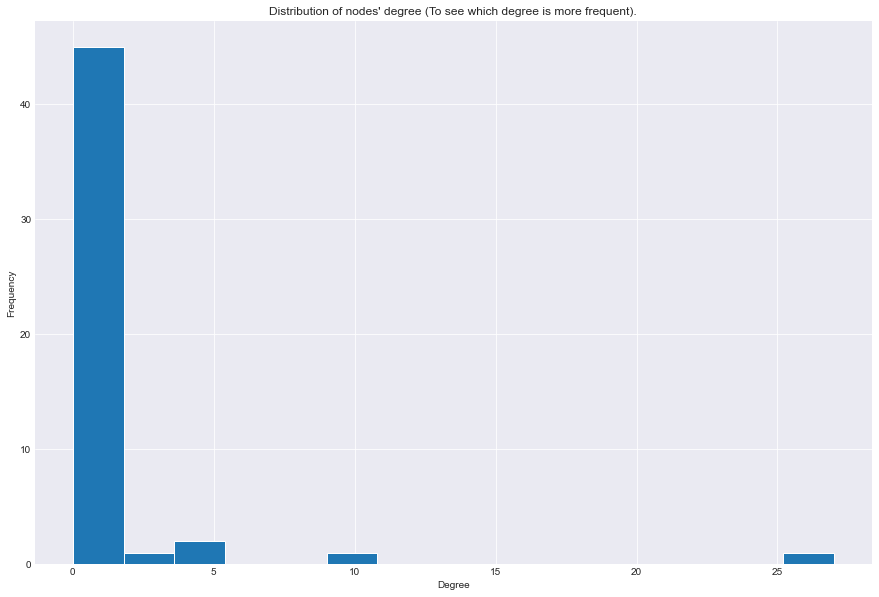

In [923]:
visualizaion_1(ControllerSystem(G_heroes, i=1, N=50, graphType=1, verbose=True))
#visualizaion_1(ControllerSystem(GHerosComics, i=1, N=2, graphType=2), limit=100)

### Visualization 2 - Visualize centrality measure

In [924]:
def visualizaion_2(res):
    # Print formatting
    format_row = "{:>30}" * 2
    
    # 
    if res['metrics']!='ClosenessCentrality':
        mean_value = np.mean(list(res['subGraph'].values()))
        print(format_row.format("", res['metrics']))
        print(format_row.format("Average Value of all nodes:", f"{mean_value:.4f}"))
        print(format_row.format(f"For '{res['node'][0]:}':", f"{res['node'][1]:.4f}"))

In [927]:
visualizaion_2(ControllerSystem(G_heroes, 2, N=50, metrics='Betweeness', node='SPIDER-MAN/PETER PARKER'))

                                                  Betweeness
   Average Value of all nodes:                        0.0306
For 'SPIDER-MAN/PETER PARKER':                        0.2066


### Visualization 3 - Visualize the shortest-ordered route

In [928]:
def visualizaion_3(res):
    
    # Extracting path and attaching seperated seim-paths together
    path = []
    for semi_path in res['shortestPath']:
        for node in semi_path[:-1]:
            path.append(node)
    path.append(res['shortestPath'][-1][-1])
    print("The shortest walk list:\nThe path can be read line to line from left to write:")
    splitter(50)
    for i in range(len(path)//5+1):
        print ("".join(f"'{path[i*5:(i+1)*5]}'") + "\n")
    splitter(50)
    
    #######################################################################
    # Creating a subgraph to just illustrate the nodes and edges involved in the shortest path
    
    # The list of edges in the shortest path 
    edge_list = [[(edge[0], edge[1]), (edge[1], edge[2]),
                 (edge[1], edge[0]), (edge[2], edge[1])] for edge in res['shortestPath']]
    edge_list = [edge for i in edge_list for edge in i]
    # The list of nodes in the shortest path 
    node_list = list(np.unique([node for path in res['shortestPath'] for node in path]))
    
    # Building the subgraph based on nodes and edges of the shortest path
    G = res['graph']
    G = G.subgraph(node_list)
    
    # Extracting node labels
    node_labels = nx.get_node_attributes(subg,'label')
    # Attaching noded labels to their associated names
    for i in node_labels:
        node_labels[i] = i+": "+node_labels[i]
    # Plotting the graph
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(12,12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color='k', node_size=400, with_labels=False)
    path_edges = list(zip(path,path[1:]))
    nx.draw_networkx_nodes(subg, pos, nodelist=path, node_color='k')
    nx.draw_networkx_edges(subg, pos, edgelist=path_edges, edge_color='seagreen', width=10)
    #node_labels = nx.get_node_attributes(subg,'label')
    nx.draw_networkx_labels(subg, pos, labels = node_labels, font_color='r',
                            font_weight='15', verticalalignment='top')
    ax.set_facecolor('whitesmoke')
    ax.axis('equal')
    fig.set_facecolor('whitesmoke')
    #plt.axis('equal')
    plt.show()


The shortest walk list:
The path can be read line to line from left to write:
'['SPIDER-MAN/PETER PARKER', 'A 11', 'CAPTAIN AMERICA', "A '00", 'IRON MAN/TONY STARK']'

'['A 1', 'THING/BENJAMIN J. GR', 'A 1', 'THOR/DR. DONALD BLAK']'



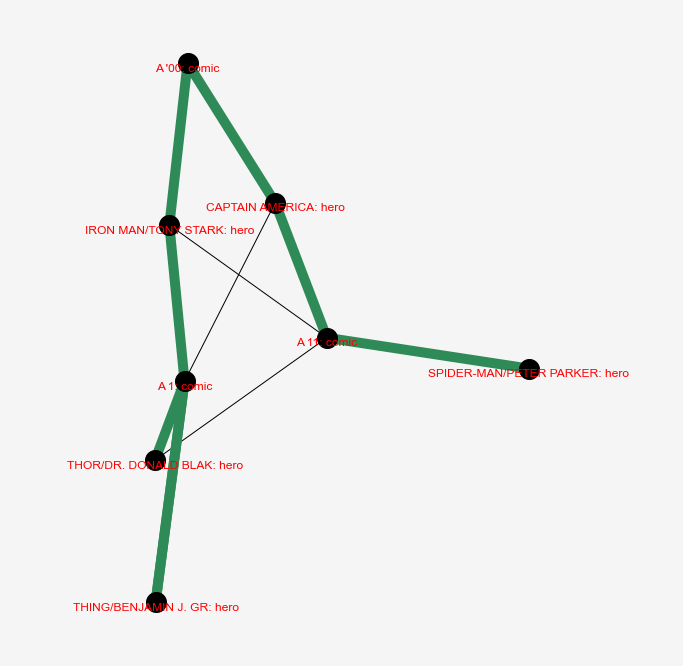

In [929]:
top_heroes = getTopNHeroes(5)
visualizaion_3(ControllerSystem(GHerosComics, 3, N=5, init_node=top_heroes[0], end_node=top_heroes[-1], h=top_heroes[1:-1]))

### Visualization 4 - Visualize the disconnected graph

In [808]:
def visualizaion_4(res):
    
    # Extracting resutls of the functionality
    min_n_links, subsetA, subsetB, G = res
    splitter(50)
    print(f"The number of links that should be disconnected: {min_n_links}")
    splitter(50)
    
    # Plot the graph before disconnections
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(12,12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color='k', node_size=400, with_labels=True, font_color='r', font_size=9)
    ax.set_facecolor('whitesmoke')
    ax.set_title('Graph before disconnection.')
    ax.axis('equal')
    fig.set_facecolor('whitesmoke')
    #plt.axis('equal')
    plt.show()
    
    # Plot disconnected graphs
    # First one
    fig, ax = plt.subplots(figsize=(12,12))
    pos = nx.spring_layout(subsetA)
    nx.draw(subsetA, pos, node_color='k', node_size=400, with_labels=True, font_color='r', font_size=9)
    ax.set_facecolor('whitesmoke')
    ax.set_title('First disconnected graph.')
    ax.axis('equal')
    fig.set_facecolor('whitesmoke')
    #plt.axis('equal')
    plt.show()
    
    # First two
    fig, ax = plt.subplots(figsize=(12,12))
    pos = nx.spring_layout(subsetB)
    nx.draw(subsetB, pos, node_color='k', node_size=400, with_labels=True, font_color='r', font_size=9)
    ax.set_facecolor('whitesmoke')
    ax.set_title('First disconnected graph.')
    ax.axis('equal')
    fig.set_facecolor('whitesmoke')
    #plt.axis('equal')
    plt.show()

The number of links that should be disconnected: 2051


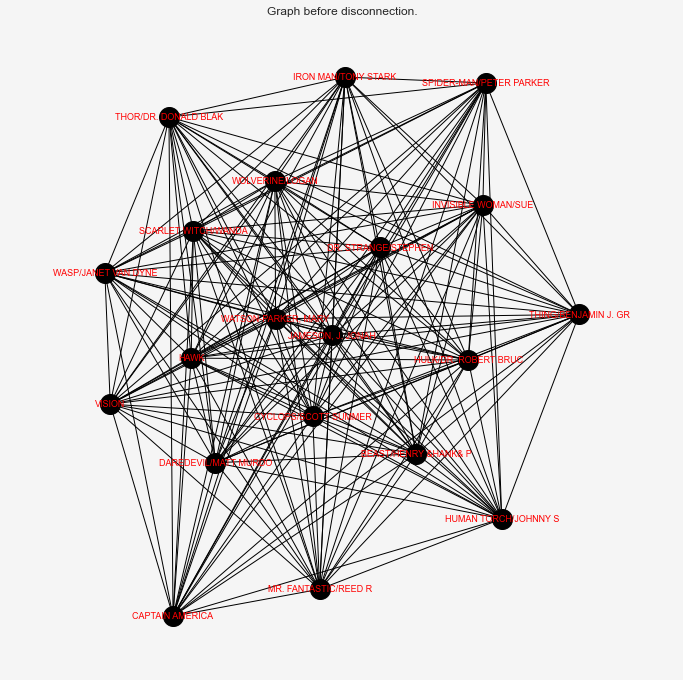

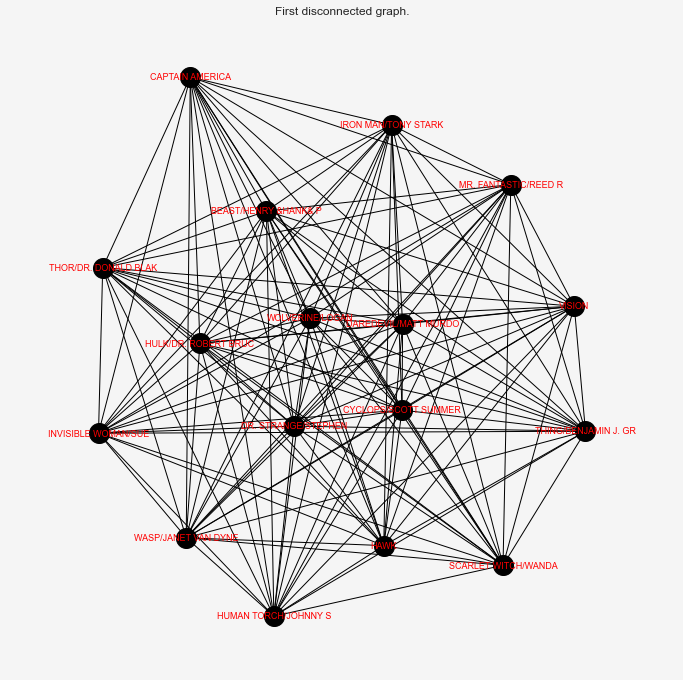

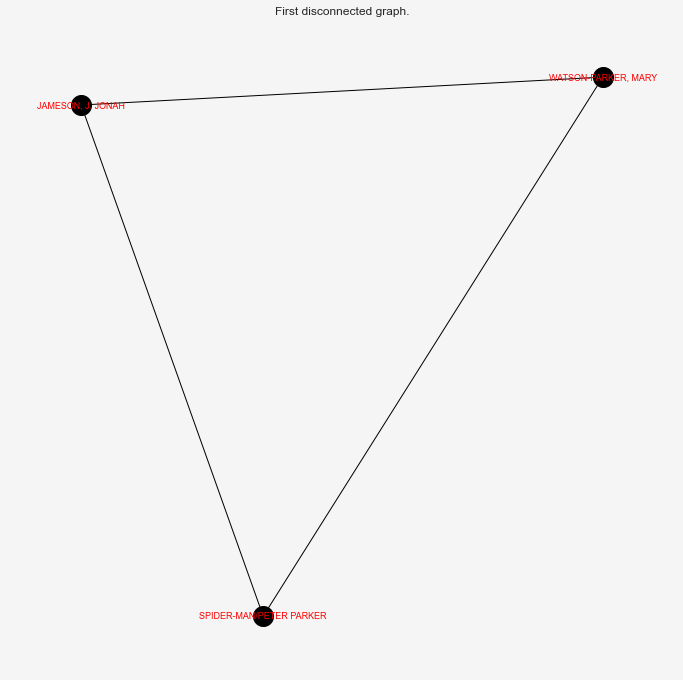

In [809]:
visualizaion_4(ControllerSystem(G_heroes, 4, 20, heroA='IRON MAN/TONY STARK', heroB='SPIDER-MAN/PETER PARKER'))

### Visualization 5 - Visualize the communities

In [839]:
def visualization_5(res):
    min_edges, communities, same_community, G = res
    splitter(50)
    print(f"Minimum number of links that must be removed to have communities: {min_edges}")
    splitter(50)
    
    # Plot the graph before disconnections
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(12,12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color='k', node_size=400, with_labels=True, font_color='r', font_size=9)
    ax.set_facecolor('whitesmoke')
    ax.set_title('Graph before disconnection.')
    ax.axis('equal')
    fig.set_facecolor('whitesmoke')
    #plt.axis('equal')
    plt.show()
    
    # Plotting communities
    for i in communities:
        communityNodes = list(i)
        sub_graph_1 = G.subgraph(communityNodes)
        fig, ax = plt.subplots(figsize=(12,12))
        pos = nx.spring_layout(sub_graph_1)
        nx.draw(sub_graph_1, pos, node_color='k', node_size=400, with_labels=True, font_color='r', font_size=9)
        ax.set_facecolor('whitesmoke')
        ax.set_title(f'Community Graph {i+1}')
        ax.axis('equal')
        fig.set_facecolor('whitesmoke')
        #plt.axis('equal')
        plt.show()

Minimum number of links that must be removed to have communities: 327


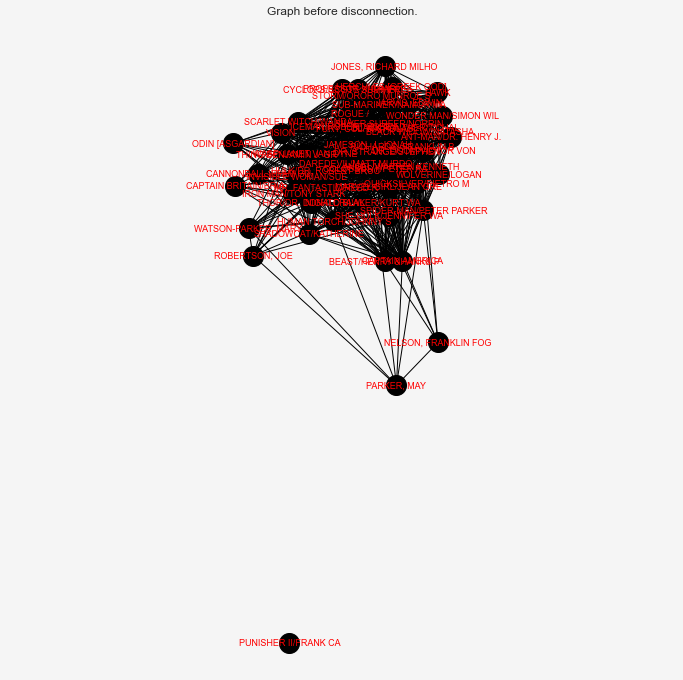

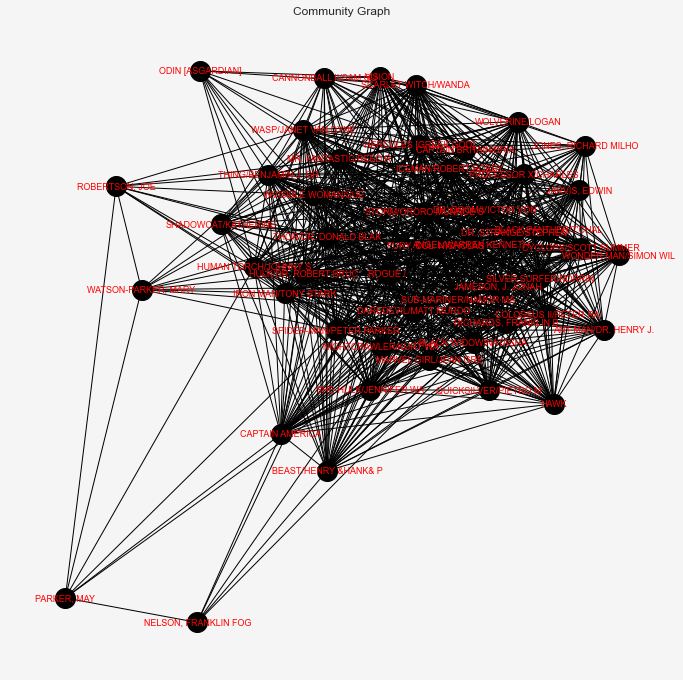

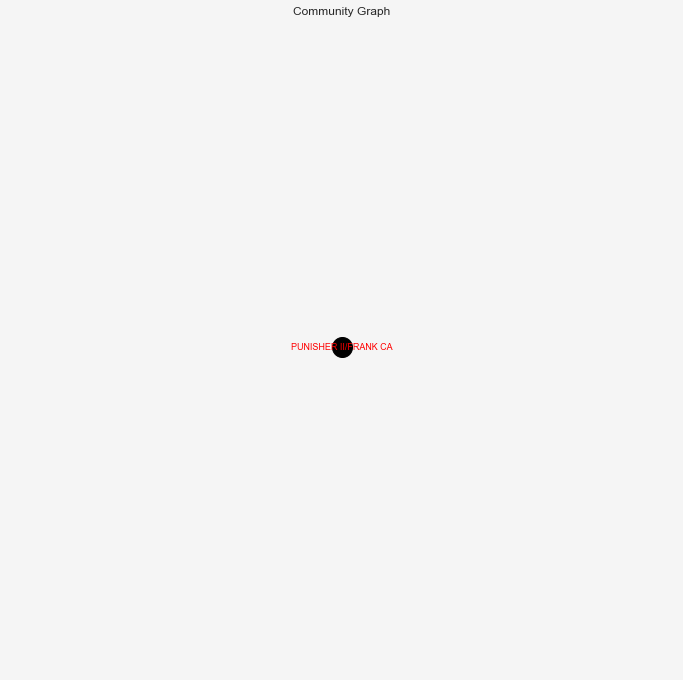

In [934]:
visualization_5(ControllerSystem(G_heroes, 5, 50, Hero_1='CAPTAIN AMERICA', Hero_2='IRON MAN/TONY STARK'))

## 6. Algorithmic Question

In [930]:
def pathCounter(grid, marked, query):
    
    # When an emtpy query is passed, it marks the end of path.
    if not query:
        return 1

    # Initializing a counter, marking the starting node as visited, and preparing
    # the next direction in the query to be looked at
    x, y = marked[-1]
    counter = 0
    d = query[0]
    boundary = len(grid)

    # Calculate the position of the next cell in this direction
    for i in range(1, 3):
        dx, dy = (0, 0)
        if d == 'R':
            dx = -i
        elif d == 'L':
            dx = i
        elif d == 'U':
            dy = -i
        elif d == 'D':
            dy = i

        # Defnining temporary parameters to reduce run-time in conditional statement comparisons
        xTemp = x+dx
        yTemp = y+dy
        
        # In the case of one segment move, check if the boundaries are respected 
        # and if the next point is not already visited.       
        if i == 1 and (xTemp < 0 or xTemp >= boundary or yTemp < 0 or yTemp >= boundary or 
                       (xTemp, yTemp) in marked):
            break
            
        # While in the case of two segment move, we must also check the point in between to not 
        # be in the marked list
        if i == 2 and (xTemp < 0 or xTemp >= boundary or yTemp < 0 or yTemp >= boundary or 
                       (xTemp, yTemp) in marked or (x + dx//2, y + dy//2) in marked):
            break
        
        # In the case of two segment move, we mark the intermediat node as visited.
        if i == 2:
            marked.append((x + dx//2, y + dy//2))
            
        # Add the next cell to the makred list and move the path there
        marked.append((x + dx, y + dy))
        
        # Recrusion function implementation which allows us to search through the possible paths
        # from the latest point we added to marked:
        counter += pathCounter(grid, marked, query[1:])
        
        # After finding all possible paths, getting bach to the root point and explore
        # further
        if i == 2:
            marked.pop()
        marked.pop()
        
    return counter

In [931]:
def preprocessing(query):
    
    # Initializing a 3x3 grid 
    grid = [[False] * 3 for _ in range(3)]
    
    # Counting the number of paths generated
    countedPaths = 0

    # Iterate over all the cells in the grid
    for i in range(3):
        for j in range(3):
            # Starting point in the grid to do path exploration
            startingPoint = (i, j)

            # Call the recursive function to generate the paths
            countedPaths += pathCounter(grid, [startingPoint], query)

    return countedPaths

In [932]:
inputString = input()
preprocessing(inputString)

DRU


15

In [933]:
inputString = input()
preprocessing(inputString)

U


9